In [6]:
# ========================= init phase =========================
import os
from typing import Any
import numpy as np
from numpy import ndarray
import torch
from torch.utils.data import TensorDataset
import torch.utils.data as data
from Ashare import *
import pandas as pd
import torch.nn as nn
import pathlib
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"torch version: {torch.__version__} device: {device}")
project_dir = pathlib.Path('.').absolute()

models_dir = os.path.join(project_dir, 'models')
images_dir = os.path.join(project_dir, 'images')


def make_sure_dir_exists(dir):
    os.makedirs(dir, exist_ok=True)


make_sure_dir_exists(models_dir)
make_sure_dir_exists(images_dir)
LSTM_bin_classification_model_dir = os.path.join(models_dir, 'LSTM_bin_classification')

print(f"model_dir: {models_dir}")
print(f"images_dir: {images_dir}")

torch version: 2.3.0+cu121 device: cuda
model_dir: D:\college\NLP\stock_price_predict\models
images_dir: D:\college\NLP\stock_price_predict\images


In [7]:
# ========================= data phase =========================

def produce_data(stock_code: str, day_nums: int) -> pd.DataFrame:
    """
    get raw data from internet or somewhere, just get , not handle the data
    :param stock_code:
    :param day_nums:
    :return:
    """
    return get_price(stock_code, frequency='1d', count=day_nums)


def process_data(stock_code: str, day_nums: int) -> pd.DataFrame:
    """
    handle the raw data, not for the train phase
    :param stock_code:
    :param day_nums:
    :return:
    """
    data = produce_data(stock_code, day_nums)

    # drop null sample
    data = data.dropna()
    # drop the rows containing the 0
    data = data[~(data == 0).any(axis=1)]

    # get data
    # print(data.shape)

    # we define the problem that we predict close price of a day use the previous days_seq_len day's data
    return data


def get_data(stock_code: str, day_nums: int) -> pd.DataFrame:
    """
    the interface to get the preliminary data
    :param stock_code:
    :param day_nums:
    :return:
    """
    return process_data(stock_code, day_nums)


In [32]:
# ========================= model phase =========================
# define the model
class LSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, out_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, out_dim)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)

        return out


def get_model(model_name: str, *args, **kwargs) -> nn.Module:
    model_name = model_name.lower()
    if model_name == 'lstm':
        model = LSTM(**kwargs)
    else:
        raise ValueError(f"model_name: {model_name} is not supported")
    return model


def data_set_label(data: pd.DataFrame, days_seq_len: int) -> pd.DataFrame:
    """
    sample the data
    return the dataset to train the model
    :param data:
    :param days_seq_len:
    :return:
    """
    data_with_label = data.copy()
    # let's get the label first
    # label is binary, if the close price rises, the value is 1, otherwise, the value is 0
    data_with_label.loc[:, 'next_close'] = data_with_label['close'].shift(-days_seq_len)
    # drop the last sample
    data_with_label = data_with_label.dropna()

    data_with_label.loc[:, 'label'] = (data_with_label['next_close'] - data_with_label['close']).apply(
        lambda x: 1 if x > 0 else 0)
    data_with_label = data_with_label.drop('next_close', axis=1)
    return data_with_label


def data_sequence_modeling(data: pd.DataFrame, days_seq_len: int) -> tuple[ndarray, Any, Any]:
    """
    data sequence modeling
    :param days_seq_len:
    :param data:
    :return:
    """
    label = data.loc[:, 'label'][days_seq_len:].values
    label = label.reshape(-1, 1)
    unprocessed_features = data.drop(['label'], axis=1)

    # so let's go on to deal with the data, remember we need our data to become dataset!
    # we already know that our feature is not a matrix like before, it is a 3-D tensor in shape of (sample_size, sequence_len, feature_dim)
    sample_size = label.shape[0]
    # print(sample_size, sequence_len, feature_dim)

    # we need to prepare for the features of every sample
    features = []
    for sample_idx in range(0, sample_size):
        sample_features = []
        for day_idx in range(days_seq_len):
            sample_features.append(unprocessed_features.iloc[sample_idx + day_idx, :])
        features.append(sample_features)
    features = np.array(features)
    time_seq = data.index[days_seq_len:]

    return features, label, time_seq


def data_split_and_preprocessing(features: ndarray, label: ndarray, test_data_ratio: float) -> tuple[Any, Any]:
    """
    data split and preprocessing
    :param test_data_ratio:
    :param features:
    :param label:
    :return:
    """
    dataset = TensorDataset(torch.from_numpy(features).float(), torch.from_numpy(label).float())

    # get train data and test data
    from torch.utils.data import random_split
    train_data_size = int((1 - test_data_ratio) * len(dataset))
    test_data_size = len(dataset) - train_data_size
    train_data, test_data = torch.utils.data.random_split(dataset, [train_data_size, test_data_size])

    # data preprocessing, only normalize the features, not the labelprint(train_data)
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    train_features = train_data.dataset.tensors[0]
    test_features = test_data.dataset.tensors[0]

    sequence_len = days_seq_len
    feature_dim = train_features.shape[2]

    train_features = scaler.fit_transform(train_features.reshape(-1, feature_dim)).reshape(-1, sequence_len,
                                                                                           feature_dim)
    test_features = scaler.transform(test_features.reshape(-1, feature_dim)).reshape(-1, sequence_len, feature_dim)

    train_data = TensorDataset(torch.from_numpy(train_features).float(), train_data.dataset.tensors[1])
    test_data = TensorDataset(torch.from_numpy(test_features).float(), test_data.dataset.tensors[1])

    return train_data, test_data


def dataset_prepare(raw_data: pd.DataFrame, days_seq_len: int, test_data_ratio: float) -> tuple[Any, Any, Any]:
    """
    get the train dataset and test dataset and the time sequence
    :param test_data_ratio:
    :param raw_data:
    :param days_seq_len:
    :return:
    """
    data_with_label = data_set_label(raw_data, days_seq_len)
    features, label, time_seq = data_sequence_modeling(data_with_label, days_seq_len)
    train_dataset, test_dataset = data_split_and_preprocessing(features, label, test_data_ratio)
    return train_dataset, test_dataset, time_seq


# save the model
def save_model(model: torch.nn.Module, model_dir: str, model_acc: float):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_name = 'LSTM_bin_classification.pth'
    model_path = os.path.join(model_dir, model_name)
    # delete the previous model
    if os.path.exists(model_path):
        os.remove(model_path)
    torch.save(model.state_dict(), model_path)
    # save the accuracy
    with open(os.path.join(model_dir, 'accuracy.txt'), 'w') as f:
        f.write(str(model_acc))

    print('Model saved at {}'.format(model_path), 'Accuracy:', model_acc)


def train(model: nn.Module, train_loader: data.DataLoader, test_loader: data.DataLoader, criterion: nn.Module,
          num_epochs: int, ) -> tuple[nn.Module, list[float], list[float], list[float], list[float]]:
    # train the model
    train_loss = []
    test_loss = []
    train_accuracy_list = []
    test_accuracy_list = []
    best_accuracy = 0
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        train_loss_sum = 0
        train_accuracy = 0
        for features, labels in train_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            train_loss_sum += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            predicted = (outputs > 0.5).float()
            # print(predicted.shape, labels.shape)
            train_accuracy += (predicted == labels).sum()
            train_accuracy = train_accuracy.item()
        # print(train_accuracy)
        # print(train_accuracy/len(train_data))
        train_loss.append(train_loss_sum / len(train_loader))
        train_accuracy_list.append(train_accuracy / len(train_loader.dataset))

        model.eval()
        test_loss_sum = 0
        test_accuracy = 0
        with torch.no_grad():
            for features, labels in test_loader:
                features = features.to(device)
                labels = labels.to(device)

                outputs = model(features)
                loss = criterion(outputs, labels)
                test_loss_sum += loss.item()

                predicted = (outputs > 0.5).float()
                test_accuracy += (predicted == labels).sum()
                test_accuracy = test_accuracy.item()
        test_loss.append(test_loss_sum / len(test_loader))
        test_accuracy_list.append(test_accuracy / len(test_loader.dataset))
        if test_accuracy_list[-1] > best_accuracy:
            best_accuracy = test_accuracy_list[-1]
            best_model = model
            # save the model
            save_model(model, LSTM_bin_classification_model_dir, best_accuracy)

        if (epoch + 1) % 10 == 0:
            print(
                'Epoch [{}/{}], Train Loss: {:.8f}, Test Loss: {:.8f}, Train Accuracy: {:.4f}, Test Accuracy: {:.4f}'.format(
                    epoch + 1, num_epochs, train_loss[-1], test_loss[-1], train_accuracy_list[-1],
                    test_accuracy_list[-1]))

    return best_model, train_loss, test_loss, train_accuracy_list, test_accuracy_list

In [33]:
# ========================= utils =========================
def line_chart(data_list: list, label_list: list, title: str = None, xlabel: str = None, ylabel: str = None):
    assert len(data_list) == len(label_list)

    plt.figure(figsize=(20, 8))
    for idx, data in enumerate(data_list):
        plt.plot(data, label=label_list[idx])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

In [34]:
# ========================= run =========================
# ========================= data phase =========================
stock_code = 'sz399300'
day_nums = 10000
raw_data = get_data(stock_code, day_nums)

In [35]:
# ========================= model phase =========================

days_seq_len = 7
test_data_ratio = 0.3
train_dataset, test_dataset, time_seq = dataset_prepare(raw_data, days_seq_len, test_data_ratio)
sample_size, sequence_len, feature_dim = train_dataset.tensors[0].shape
print(f"sample_size: {sample_size}, sequence_len: {sequence_len}, feature_dim: {feature_dim}")


sample_size: 4708, sequence_len: 7, feature_dim: 5


In [36]:
input_dim = feature_dim
hidden_dim = 16
num_layers = 2
out_dim = 1
batch_size = 32
learning_rate = 0.01
num_epochs = 500

# prepare the data loader
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = LSTM(input_dim, hidden_dim, num_layers, out_dim).to(device)
print(model)

LSTM(
  (lstm): LSTM(5, 16, num_layers=2, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [37]:
# define the loss function and the optimizer
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# train the model
best_model, train_loss, test_loss, train_accuracy_list, test_accuracy_list = train(model, train_loader, test_loader,
                                                                                   criterion,
                                                                                   num_epochs)


Model saved at D:\college\NLP\stock_price_predict\models\LSTM_bin_classification\LSTM_bin_classification.pth Accuracy: 0.5507646559048428
Model saved at D:\college\NLP\stock_price_predict\models\LSTM_bin_classification\LSTM_bin_classification.pth Accuracy: 0.5516142735768904
Model saved at D:\college\NLP\stock_price_predict\models\LSTM_bin_classification\LSTM_bin_classification.pth Accuracy: 0.5656329651656754
Model saved at D:\college\NLP\stock_price_predict\models\LSTM_bin_classification\LSTM_bin_classification.pth Accuracy: 0.5662701784197112
Epoch [10/500], Train Loss: 0.68314605, Test Loss: 0.68067182, Train Accuracy: 0.5482, Test Accuracy: 0.5663
Model saved at D:\college\NLP\stock_price_predict\models\LSTM_bin_classification\LSTM_bin_classification.pth Accuracy: 0.566482582837723
Model saved at D:\college\NLP\stock_price_predict\models\LSTM_bin_classification\LSTM_bin_classification.pth Accuracy: 0.5703058623619371
Model saved at D:\college\NLP\stock_price_predict\models\LSTM_bi

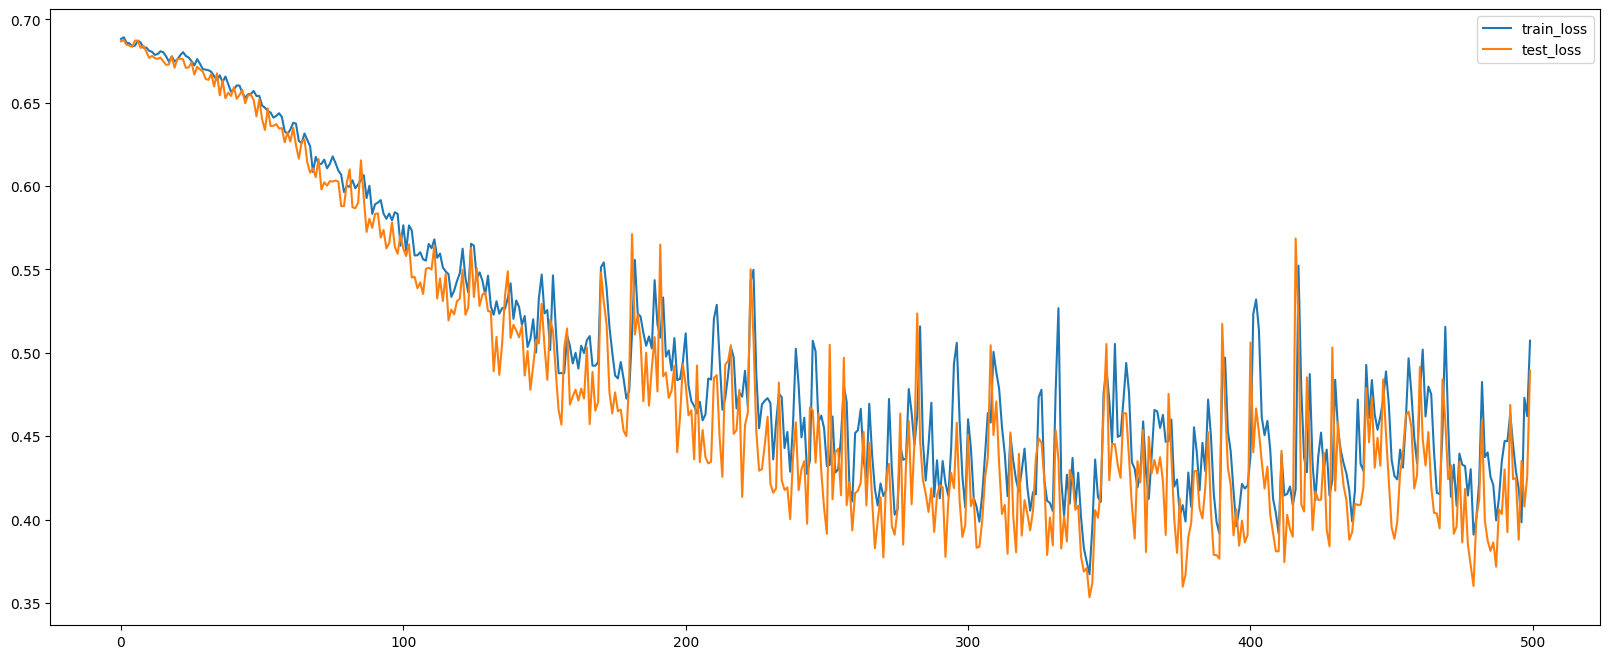

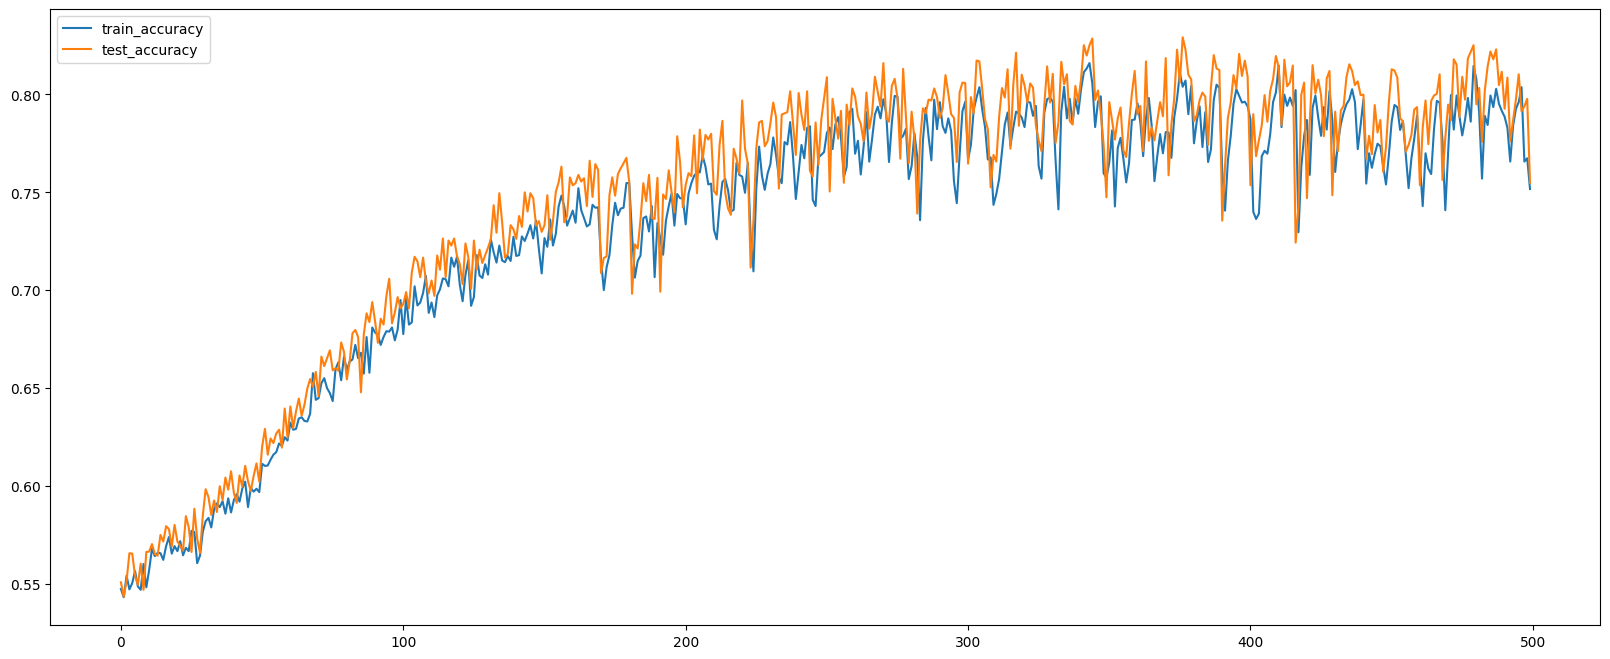

In [38]:
line_chart([train_loss, test_loss], ['train_loss', 'test_loss'], '')
plt.savefig(os.path.join(images_dir, 'loss.png'))

line_chart([train_accuracy_list, test_accuracy_list], ['train_accuracy', 'test_accuracy'], '')
plt.savefig(os.path.join(images_dir, 'accuracy.png'))
